In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, multivariate_normal
from scipy.signal import convolve2d, fftconvolve
from scipy.interpolate import RegularGridInterpolator
from pathlib import Path

In [17]:
color_max = "#ffb000"
color_t20 = "#648fff"
color_be = "#dc267f"
color_t19 = "#785ef0"

In [21]:
# https://stats.stackexchange.com/questions/64680/how-to-determine-quantiles-isolines-of-a-multivariate-normal-distribution
q2sigma = lambda q: - 2 * np.log(1 - q)
sigma2q = lambda sigma: 1 - np.exp(-sigma / 2)

In [4]:
d_board = 451e-3 # (m)
d_bull = 31.8e-3 # (m)
d_dbull = 12.7e-3 # (m)
d_triple = 214e-3 # (m)
d_double = 340e-3 # (m)
w_ring = 8e-3 # (m)
# w_wire = 1.5e-3 # (m)
alpha = 18 # (deg)

dx = 1e-3 # (m)
dy = 1e-3 # (m)
x = np.arange(- d_board / 2, d_board / 2, dx)
y = np.arange(- d_board / 2, d_board / 2, dy)

x_g, y_g = np.meshgrid(x, y, indexing="xy")

r_g = np.sqrt(x_g ** 2 + y_g ** 2)
phi_g = 180 / np.pi * np.arctan2(y_g, x_g)
phi_g[phi_g < 0] += 360

In [5]:
factors = np.ones_like(r_g)
points = 0 * np.ones_like(phi_g)

points[(r_g <= d_dbull / 2)] = 50
points[(r_g > d_dbull / 2) & (r_g <= d_bull / 2)] = 25

points[(r_g > d_bull / 2) & ((phi_g > 360 - alpha / 2) | (phi_g <= alpha / 2))] = 6
points[(r_g > d_bull / 2) & (phi_g > alpha / 2) & (phi_g <= 3 * alpha / 2)] = 13
points[(r_g > d_bull / 2) & (phi_g > 3 * alpha / 2) & (phi_g <= 5 * alpha / 2)] = 4
points[(r_g > d_bull / 2) & (phi_g > 5 * alpha / 2) & (phi_g <= 7 * alpha / 2)] = 18
points[(r_g > d_bull / 2) & (phi_g > 7 * alpha / 2) & (phi_g <= 9 * alpha / 2)] = 1
points[(r_g > d_bull / 2) & (phi_g > 9 * alpha / 2) & (phi_g <= 11 * alpha / 2)] = 20
points[(r_g > d_bull / 2) & (phi_g > 11 * alpha / 2) & (phi_g <= 13 * alpha / 2)] = 5
points[(r_g > d_bull / 2) & (phi_g > 13 * alpha / 2) & (phi_g <= 15 * alpha / 2)] = 12
points[(r_g > d_bull / 2) & (phi_g > 15 * alpha / 2) & (phi_g <= 17 * alpha / 2)] = 9
points[(r_g > d_bull / 2) & (phi_g > 17 * alpha / 2) & (phi_g <= 19 * alpha / 2)] = 14
points[(r_g > d_bull / 2) & (phi_g > 19 * alpha / 2) & (phi_g <= 21 * alpha / 2)] = 11
points[(r_g > d_bull / 2) & (phi_g > 21 * alpha / 2) & (phi_g <= 23 * alpha / 2)] = 8
points[(r_g > d_bull / 2) & (phi_g > 23 * alpha / 2) & (phi_g <= 25 * alpha / 2)] = 16
points[(r_g > d_bull / 2) & (phi_g > 25 * alpha / 2) & (phi_g <= 27 * alpha / 2)] = 7
points[(r_g > d_bull / 2) & (phi_g > 27 * alpha / 2) & (phi_g <= 29 * alpha / 2)] = 19
points[(r_g > d_bull / 2) & (phi_g > 29 * alpha / 2) & (phi_g <= 31 * alpha / 2)] = 3
points[(r_g > d_bull / 2) & (phi_g > 31 * alpha / 2) & (phi_g <= 33 * alpha / 2)] = 17
points[(r_g > d_bull / 2) & (phi_g > 33 * alpha / 2) & (phi_g <= 35 * alpha / 2)] = 2
points[(r_g > d_bull / 2) & (phi_g > 35 * alpha / 2) & (phi_g <= 37 * alpha / 2)] = 15
points[(r_g > d_bull / 2) & (phi_g > 37 * alpha / 2) & (phi_g <= 39 * alpha / 2)] = 10

factors[r_g > d_double / 2] = 0
factors[(r_g <= d_double / 2) & (r_g > d_double / 2 - w_ring)] = 2
factors[(r_g <= d_triple / 2) & (r_g > d_triple / 2 - w_ring)] = 3

points *= factors

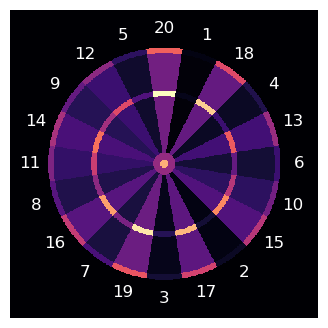

In [6]:
plt.figure(figsize=(4, 4))

plt.pcolormesh(x_g, y_g, points, rasterized="True", cmap="magma")

points_order = (6, 13, 4, 18, 1, 20, 5, 12, 9, 14, 11, 8, 16, 7, 19, 3, 17, 2, 15, 10)
for ii in range(len(points_order)):
    plt.text((d_double / 2 + (d_board - d_double) / 4) * np.cos(ii * np.pi / 180 * alpha), (d_double / 2 + (d_board - d_double) / 4) * np.sin(ii * np.pi / 180 * alpha), 
             points_order[ii], 
             horizontalalignment="center",
             verticalalignment="center",
             fontsize=12, 
             color=(1, 1, 1))
    
plt.gca().axis("off")
plt.gca().set_aspect(1)

plt.savefig(Path("..", "content", "img", "dartboard_points.svg"), dpi=600)

In [7]:
accuracy_50 = 1e-3 * np.linspace(1, 200, 200) # (m)
accuracy_95 = accuracy_50 * q2sigma(0.95) / q2sigma(0.5) # (m)

mu = 0 # (m)
sigma = accuracy_50 / q2sigma(0.5) # (m)
n_sigma = 3

points_expected = np.zeros((*np.shape(x_g), len(sigma)))

r_t20 = d_triple / 2 - w_ring / 2
phi_t20 = 90
x_t20 = r_t20 * np.cos(np.pi * phi_t20 / 180)
y_t20 = r_t20 * np.sin(np.pi * phi_t20 / 180)
points_expected_t20 = np.ones_like(sigma)

r_be = 0
phi_be = 0
x_be = r_be * np.cos(np.pi * phi_be / 180)
y_be = r_be * np.sin(np.pi * phi_be / 180)
points_expected_be = np.ones_like(sigma)

r_t19 = d_triple / 2 - w_ring / 2
phi_t19 = 252
x_t19 = r_t19 * np.cos(np.pi * phi_t19 / 180)
y_t19 = r_t19 * np.sin(np.pi * phi_t19 / 180)
points_expected_t19 = np.ones_like(sigma)

x_max = np.ones_like(sigma)
y_max = np.ones_like(sigma)
points_expected_max = np.ones_like(sigma)

for ii in range(len(accuracy_50)):
    x_psf = np.arange(-n_sigma * sigma[ii], n_sigma * sigma[ii], dx)
    y_psf = np.arange(-n_sigma * sigma[ii], n_sigma * sigma[ii], dy)
    x_psf, y_psf = np.meshgrid(x_psf, y_psf, indexing="xy")
    r_psf = np.sqrt(x_psf ** 2 + y_psf ** 2)
    
    psf = norm(loc=mu, scale=sigma[ii]).pdf(r_psf)
    psf /= np.sum(psf)

    # points_expected[:, :, ii] = convolve2d(points, psf, mode="same", boundary="fill", fillvalue=0)
    points_expected[:, :, ii] = fftconvolve(points, psf, mode="same")

    points_expected_t20[ii] = RegularGridInterpolator((x, y), points_expected[:, :, ii].T)((x_t20, y_t20))
    points_expected_be[ii] = RegularGridInterpolator((x, y), points_expected[:, :, ii].T)((x_be, y_be))
    points_expected_t19[ii] = RegularGridInterpolator((x, y), points_expected[:, :, ii].T)((x_t19, y_t19))
    
    idx_max = np.unravel_index(np.argmax(points_expected[:, :, ii]), np.shape(points_expected[:, :, ii]))    
    points_expected_max[ii] = points_expected[:, :, ii][idx_max]
    x_max[ii] = x_g[idx_max]
    y_max[ii] = y_g[idx_max]

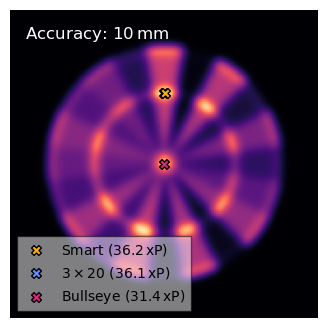

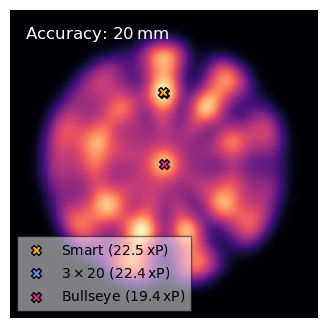

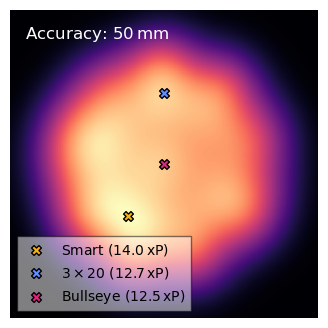

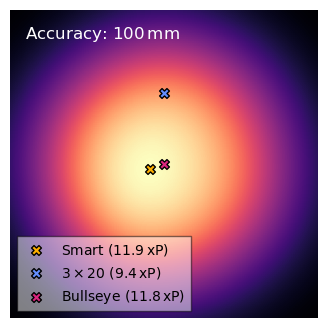

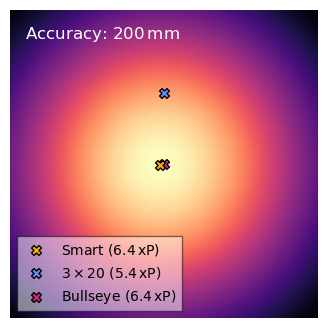

In [8]:
for ii in range(len(accuracy_50)):    
    if np.isin(accuracy_50[ii], [10e-3, 20e-3, 50e-3, 100e-3, 200e-3]):        
        plt.figure(figsize=(4, 4))
                  
        plt.text(0.05, 0.95, f"Accuracy: ${accuracy_50[ii] * 1e3:.0f}\,$mm", 
                 horizontalalignment="left",
                 verticalalignment="top",
                 color=(1, 1, 1),
                 fontsize=12,
                 transform=plt.gca().transAxes)      

        plt.pcolormesh(x_g, y_g, points_expected[:, :, ii], rasterized="True", cmap="magma")
        plt.scatter(x_max[ii], y_max[ii], edgecolor=(0, 0, 0), facecolor=color_max, s=50, marker="X", label=f"Smart $({points_expected_max[ii]:.1f}\,$xP$)$", zorder=25)
        plt.scatter(x_t20, y_t20, edgecolor=(0, 0, 0), facecolor=color_t20, s=50, marker="X", label=f"$3\\times 20$ $({points_expected_t20[ii]:.1f}\,$xP$)$", zorder=20)
        plt.scatter(x_be, y_be, edgecolor=(0, 0, 0), facecolor=color_be, s=50, marker="X", label=f"Bullseye $({points_expected_be[ii]:.1f}\,$xP$)$", zorder=15)
        
        plt.gca().axis("off")
        plt.gca().set_aspect(1)
        plt.legend(loc="lower left", fancybox=False, framealpha=0.5, edgecolor=(0, 0, 0))
        
        plt.savefig(Path("..", "content", "img", f"xpoints_acc{accuracy_50[ii] * 1e3:.0f}mm.svg", dpi=600, bbox_inches="tight"))

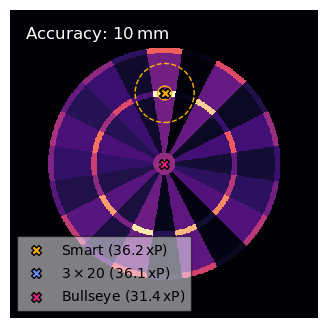

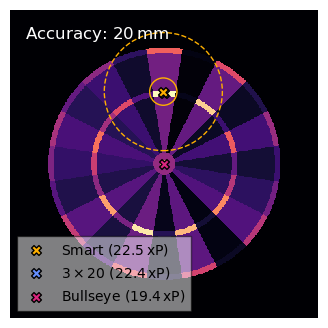

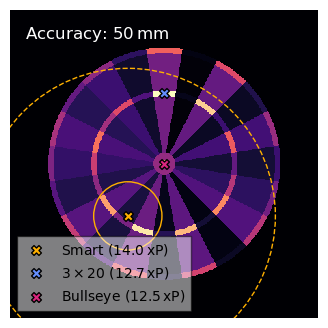

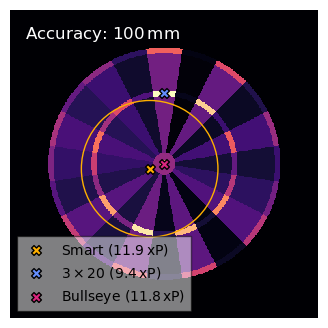

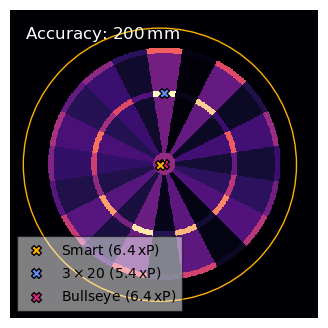

In [9]:
for ii in range(len(accuracy_50)):
    if np.isin(accuracy_50[ii], [10e-3, 20e-3, 50e-3, 100e-3, 200e-3]):        
        plt.figure(figsize=(4, 4))
                  
        plt.text(0.05, 0.95, f"Accuracy: ${accuracy_50[ii] * 1e3:.0f}\,$mm", 
                 horizontalalignment="left",
                 verticalalignment="top",
                 color=(1, 1, 1),
                 fontsize=12,
                 transform=plt.gca().transAxes)      

        plt.pcolormesh(x_g, y_g, points, rasterized="True", cmap="magma")
        plt.scatter(x_max[ii], y_max[ii], edgecolor=(0, 0, 0), facecolor=color_max, s=50, marker="X", label=f"Smart $({points_expected_max[ii]:.1f}\,$xP$)$", zorder=25)
        plt.scatter(x_t20, y_t20, edgecolor=(0, 0, 0), facecolor=color_t20, s=50, marker="X", label=f"$3\\times 20$ $({points_expected_t20[ii]:.1f}\,$xP$)$", zorder=20)
        plt.scatter(x_be, y_be, edgecolor=(0, 0, 0), facecolor=color_be, s=50, marker="X", label=f"Bullseye $({points_expected_be[ii]:.1f}\,$xP$)$", zorder=15)
                
        circle_1 = plt.Circle((x_max[ii], y_max[ii]), accuracy_50[ii], facecolor="None", edgecolor=color_max)
        circle_2 = plt.Circle((x_max[ii], y_max[ii]), accuracy_95[ii], facecolor="None", edgecolor=color_max, linestyle="--")
        plt.gca().add_artist(circle_1)
        plt.gca().add_artist(circle_2)
        
        plt.gca().axis("off")
        plt.gca().set_aspect(1)
        plt.legend(loc="lower left", fancybox=False, framealpha=0.5, edgecolor=(0, 0, 0))
        
        plt.savefig(Path("..", "content", "img", f"points_acc{accuracy_50[ii] * 1e3:.0f}mm.svg", dpi=600, bbox_inches="tight"))

25.0 mm


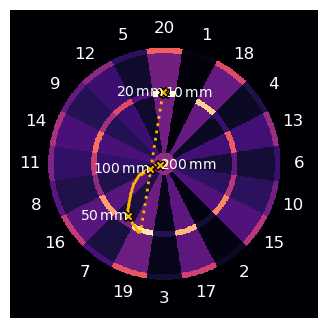

In [12]:
plt.figure(figsize=(4, 4))

plt.pcolormesh(x_g, y_g, points, rasterized="True", cmap="magma", zorder=5)

for ii in range(len(accuracy_50)):
    if np.isin(accuracy_50[ii], [10e-3, 20e-3, 50e-3, 100e-3, 200e-3]):
        plt.scatter(x_max[ii], y_max[ii], edgecolor=(0, 0, 0), facecolor=color_max, s=50, marker="X", zorder=20)
        
        if np.isin(accuracy_50[ii], [10e-3, 200e-3]):
            h_align = "left"
        else:
            h_align = "right"
       
        plt.text(x_max[ii], y_max[ii], f"${accuracy_50[ii] * 1e3:.0f}\,$mm",
            horizontalalignment=h_align,
            verticalalignment="center",
            color=(1, 1, 1),
            fontsize=10,
            zorder=25)

split_index = 24
plt.plot(x_max[:split_index], y_max[:split_index], color=color_max, linestyle=":", linewidth=2, zorder=10)
plt.plot(x_max[split_index:], y_max[split_index:], color=color_max, linestyle="-", linewidth=2, zorder=10)
print(f"{1e3 * accuracy_50[split_index]:.1f} mm")

for ii in range(len(points_order)):
    plt.text((d_double / 2 + (d_board - d_double) / 4) * np.cos(ii * np.pi / 180 * alpha), (d_double / 2 + (d_board - d_double) / 4) * np.sin(ii * np.pi / 180 * alpha), 
             points_order[ii], 
             horizontalalignment="center",
             verticalalignment="center",
             fontsize=12, 
             color=(1, 1, 1),
             zorder=6)
        
plt.gca().axis("off")
plt.gca().set_aspect(1)

plt.savefig(Path("..", "content", "img", "optimal_strategy.svg", dpi=600, bbox_inches="tight"))

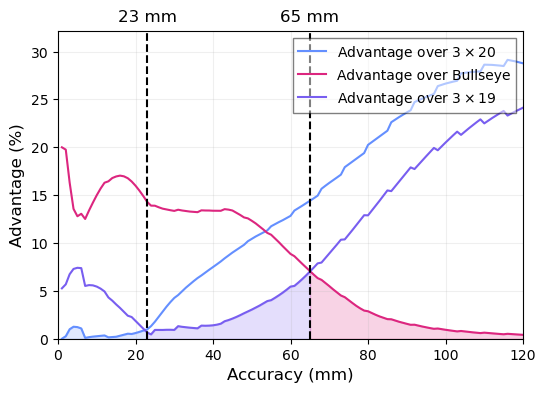

In [13]:
advantage_t20 = 100 * (points_expected_max - points_expected_t20) / points_expected_t20
advantage_be = 100 * (points_expected_max - points_expected_be) / points_expected_be
advantage_t19 = 100 * (points_expected_max - points_expected_t19) / points_expected_t19

x_lim = [0, 120]
y_lim = [0, 1.1 * np.max([np.max(advantage) for advantage in [advantage_t20, advantage_t19, advantage_be]])]

index_t20_t19 = 22
index_t19_be = 64

plt.figure(figsize=(6, 4))

plt.plot(1e3 * accuracy_50, advantage_t20, 
         color=color_t20, 
         label="Advantage over $3\\times 20$")
plt.plot(1e3 * accuracy_50, advantage_be, color=color_be, 
         label="Advantage over Bullseye")
plt.plot(1e3 * accuracy_50, advantage_t19, color=color_t19,
         label="Advantage over $3\\times 19$")

plt.axvline(1e3 * accuracy_50[index_t20_t19], linestyle="--", color=(0, 0, 0))
plt.axvline(1e3 * accuracy_50[index_t19_be], linestyle="--", color=(0, 0, 0))

plt.text(1e3 * accuracy_50[index_t20_t19] / np.ptp(x_lim), 1.02, f"{1e3 * accuracy_50[index_t20_t19]:.0f} mm",
        horizontalalignment="center",
        verticalalignment="bottom",
        fontsize=12,
        transform=plt.gca().transAxes,
        zorder=5)
plt.text(1e3 * accuracy_50[index_t19_be] / np.ptp(x_lim), 1.02, f"{1e3 * accuracy_50[index_t19_be]:.0f} mm",
        horizontalalignment="center",
        verticalalignment="bottom",
        fontsize=12,
        transform=plt.gca().transAxes,
        zorder=5)

plt.fill_between(1e3 * accuracy_50[:index_t20_t19 + 1], 0, advantage_t20[:index_t20_t19 + 1], color=color_t20, alpha=0.2)
plt.fill_between(1e3 * accuracy_50[index_t20_t19:index_t19_be + 1], 0, advantage_t19[index_t20_t19:index_t19_be + 1], color=color_t19, alpha=0.2)
plt.fill_between(1e3 * accuracy_50[index_t19_be:], 0, advantage_be[index_t19_be:], color=color_be, alpha=0.2)

plt.xlabel("Accuracy (mm)", fontsize=12)
plt.ylabel("Advantage (%)", fontsize=12)
plt.xlim(x_lim)
plt.ylim(y_lim)
plt.gca().tick_params(axis="both", which="major", labelsize=10)
plt.grid(alpha=0.2)

plt.legend(loc="upper right", fancybox=False, framealpha=0.5, edgecolor=(0, 0, 0))

plt.savefig(Path("..", "content", "img", f"advantage_accuracy_all.svg", dpi=600, bbox_inches="tight"))

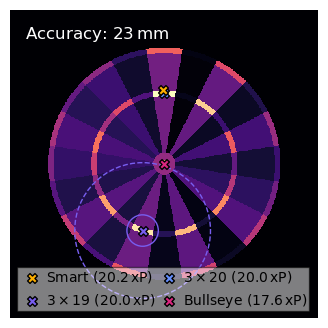

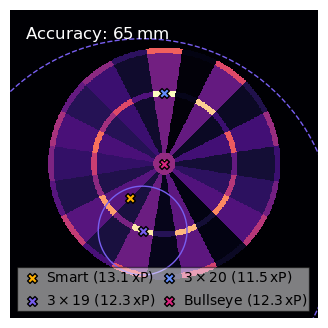

In [14]:
for ii in [index_t20_t19, index_t19_be]:        
    plt.figure(figsize=(4, 4))
              
    plt.text(0.05, 0.95, f"Accuracy: ${accuracy_50[ii] * 1e3:.0f}\,$mm", 
             horizontalalignment="left",
             verticalalignment="top",
             color=(1, 1, 1),
             fontsize=12,
             transform=plt.gca().transAxes)      

    plt.pcolormesh(x_g, y_g, points, rasterized="True", cmap="magma")
    plt.scatter(x_max[ii], y_max[ii], edgecolor=(0, 0, 0), facecolor=color_max, s=50, marker="X", label=f"Smart $({points_expected_max[ii]:.1f}\,$xP$)$", zorder=25)
    plt.scatter(x_t19, y_t19, edgecolor=(0, 0, 0), facecolor=color_t19, s=50, marker="X", label=f"$3\\times 19$ $({points_expected_t19[ii]:.1f}\,$xP$)$", zorder=25)
    plt.scatter(x_t20, y_t20, edgecolor=(0, 0, 0), facecolor=color_t20, s=50, marker="X", label=f"$3\\times 20$ $({points_expected_t20[ii]:.1f}\,$xP$)$", zorder=20)
    plt.scatter(x_be, y_be, edgecolor=(0, 0, 0), facecolor=color_be, s=50, marker="X", label=f"Bullseye $({points_expected_be[ii]:.1f}\,$xP$)$", zorder=15)
            
    circle_1 = plt.Circle((x_t19, y_t19), accuracy_50[ii], facecolor="None", edgecolor=color_t19)
    circle_2 = plt.Circle((x_t19, y_t19), accuracy_95[ii], facecolor="None", edgecolor=color_t19, linestyle="--")
    plt.gca().add_artist(circle_1)
    plt.gca().add_artist(circle_2)
    
    plt.gca().axis("off")
    plt.gca().set_aspect(1)
    plt.legend(loc="lower left", fancybox=False, framealpha=0.5, edgecolor=(0, 0, 0), ncol=2, columnspacing=0, handletextpad=0, borderpad=0.1)
    
    plt.savefig(Path("..", "content", "img", f"practical_strategy_acc{1e3 * accuracy_50[ii]:.0f}mm.svg", dpi=600, bbox_inches="tight"))

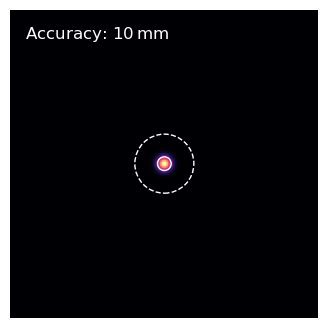

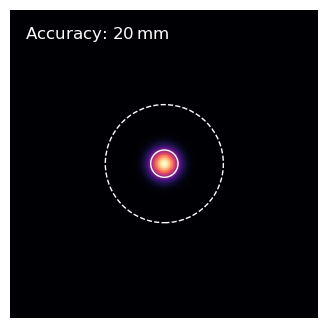

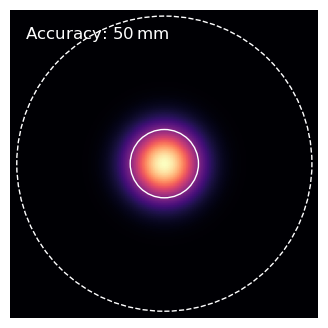

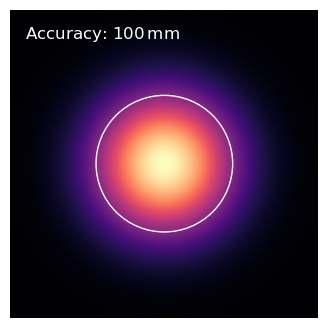

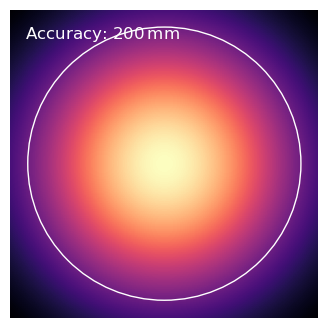

In [15]:
r_psf = r_g

for ii in range(len(accuracy_50)):        
    if np.isin(accuracy_50[ii], [10e-3, 20e-3, 50e-3, 100e-3, 200e-3]):
        psf = norm(loc=mu, scale=sigma[ii]).pdf(r_psf)
        psf /= np.sum(psf)

        plt.figure(figsize=(4, 4))
        
        plt.pcolormesh(x_g, y_g, psf, rasterized="True", cmap="magma")

        circle_1 = plt.Circle((0, 0), accuracy_50[ii], facecolor="None", edgecolor=(1, 1, 1))
        circle_2 = plt.Circle((0, 0), accuracy_95[ii], facecolor="None", edgecolor=(1, 1, 1), linestyle="--")
        plt.gca().add_artist(circle_1)
        plt.gca().add_artist(circle_2)
        
        plt.text(0.05, 0.95, f"Accuracy: ${accuracy_50[ii] * 1e3:.0f}\,$mm", 
                 horizontalalignment="left",
                 verticalalignment="top",
                 color=(1, 1, 1),
                 fontsize=12,
                 transform=plt.gca().transAxes)

        plt.gca().axis("off")
        plt.gca().set_aspect(1)
        
        plt.savefig(Path("..", "content", "img", f"psf_acc{1e3 * accuracy_50[ii]:.0f}mm.svg", dpi=600, bbox_inches="tight"))